In [2]:
import os
os.chdir('../')

In [3]:
import os
import math
import pickle
import cv2
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
import bbox_visualizer as bbv

from tqdm import tqdm
from torch.utils.data import DataLoader
from datasets.datasets import CleanDataset, SyntheticDataset
from models.faster_rcnn.faster_rcnn import get_loss_and_detection
from models.faster_rcnn.faster_rcnn import create_model, get_loss_with_logits, get_detection_with_logits, \
    get_loss_with_weights
from utils.faster_rcnn.general import transform_to_faster_rcnn_targets, collate_fn
from utils.general import coco80_to_coco91_class, check_file, box_iou, xyxy2xywh, set_logging, increment_path
from utils.crowd.earl import EARLAggregator
from utils.crowd.aggregator import NoAggregator
from utils.crowd.majority_vote import MVAggregator
from utils.crowd.bdc import BDCAggregator

In [4]:
#monkey patching
def add_label(img,
              label,
              bbox,
              size=1,
              thickness=2,
              draw_bg=True,
              text_bg_color=(255, 255, 255),
              text_color=(0, 0, 0),
              top=True, auto=True):
    """adds label, inside or outside the rectangle

    Parameters
    ----------
    img : ndarray
        the image on which the label is to be written, preferably the image with the rectangular bounding box drawn
    label : str
        the text (label) to be written
    bbox : list
        a list containing x_min, y_min, x_max and y_max of the rectangle positions
    size : int, optional
        size of the label, by default 1
    thickness : int, optional
        thickness of the label, by default 2
    draw_bg : bool, optional
        if True, draws the background of the text, else just the text is written, by default True
    text_bg_color : tuple, optional
        the background color of the label that is filled, by default (255, 255, 255)
    text_color : tuple, optional
        color of the text (label) to be written, by default (0, 0, 0)
    top : bool, optional
        if True, writes the label on top of the bounding box, else inside, by default True

    Returns
    -------
    ndarray
        the image with the label written
    """
    font = cv2.FONT_HERSHEY_SIMPLEX

    (label_width, label_height), baseline = cv2.getTextSize(label, font, size, thickness)
    if auto:
        if sum(text_bg_color) / 3  < 90:
            text_color = (255, 255, 255)
    
    if top:
        label_bg = [bbox[0], bbox[1], bbox[0] + label_width, bbox[1] - label_height - int(15 * size)]
        if draw_bg:
            cv2.rectangle(img, (label_bg[0], label_bg[1]),
                          (label_bg[2] + 5, label_bg[3]), text_bg_color, -1)

        cv2.putText(img, label, (bbox[0] + 5, bbox[1] - int(15 * size)), font, size, text_color, thickness)
    else:
        label_bg = [bbox[0], bbox[1], bbox[0] + label_width, bbox[1] + label_height + int(15 * size)]
        if draw_bg:
            cv2.rectangle(img, (label_bg[0], label_bg[1]),
                          (label_bg[2] + 5, label_bg[3]), text_bg_color, -1)
        cv2.putText(img, label, (bbox[0] + 5, bbox[1] + int(16 * size) + (4 * thickness)), font, size, text_color, thickness)
    return img
bbv.add_label = add_label

In [5]:
# load model
weights = './outputs/crowd-annotations-voc/ann25_mix-frcnn_pretrained-bdc/weights/best.pt'

device = torch.device(f"cuda:0")
ckpt = torch.load(weights, map_location='cpu')
model = ckpt['model'].half()
model.cuda().eval();

In [6]:
# load aggregators
data = './data/voc_2007_ann25_mix.yaml'

with open(data) as f:
    data_dict = yaml.load(f, Loader=yaml.SafeLoader)
    
with open('./config/mv.yaml') as f:
    ca_hyp = yaml.load(f, Loader=yaml.SafeLoader)
mv_aggregator = MVAggregator(data_dict['n_annotator'], **ca_hyp['parameters'])
mv_dataset = SyntheticDataset(img_dir=data_dict['image_dir'], annotations_path=data_dict['train'],
                              image_size=None, train=False, augments=None, aggregator=mv_aggregator, normalize_box=False,
                              clean_annotations_path=data_dict['clean_train'])

with open('./config/earl.yaml') as f:
    ca_hyp = yaml.load(f, Loader=yaml.SafeLoader)
earl_aggregator = EARLAggregator(data_dict['n_annotator'], ann_weight=data_dict['earl_ann_weights'])
earl_dataset = SyntheticDataset(img_dir=data_dict['image_dir'], annotations_path=data_dict['train'],
                              image_size=None, train=False, augments=None, aggregator=earl_aggregator, normalize_box=False,
                              clean_annotations_path=data_dict['clean_train'])

with open('./config/bdc.yaml') as f:
    ca_hyp = yaml.load(f, Loader=yaml.SafeLoader)
bdc_aggregator = ckpt['aggregator']
bdc_aggregator.conf_thres = 0.0
bdc_dataset = SyntheticDataset(img_dir=data_dict['image_dir'], annotations_path=data_dict['train'],
                              image_size=None, train=False, augments=None, aggregator=bdc_aggregator, normalize_box=False,
                              clean_annotations_path=data_dict['clean_train'])
bdc_dataset.noisy_annotations = bdc_dataset.normalize_bbox(bdc_dataset.noisy_annotations)
bdc_annotations, lower_bound = bdc_aggregator.initialize_dataset(bdc_dataset)
assert len(bdc_dataset.annotations) == len(bdc_annotations), 'this shouldnt happen'
bdc_dataset.annotations = bdc_dataset.normalize_bbox(bdc_annotations, inverse=True)

In [8]:
dataloader = DataLoader(bdc_dataset, batch_size=1, num_workers=0, pin_memory=True,
                        collate_fn=collate_fn, shuffle=False)
def get_out(model, dataloader):
    out_with_logits = []
    with torch.autocast(device_type=device.type, dtype=torch.float16):
        with torch.no_grad():
            for img, _, _, shapes, _ in tqdm(dataloader, total=len(dataloader)):
                img = list(image.to(device) for image in img)
                out = get_detection_with_logits(model, img)  # prediction already sorted
                for si, pred in enumerate(out):
                    oh, ow = shapes[si][0]  # normalize box
                    ori_dims = np.asarray([ow, oh, ow, oh], dtype=np.float32)[np.newaxis, :]
                    pred_box = pred['boxes'].clone().detach().cpu().numpy().astype(np.float32) / ori_dims
                    logits = pred['logits'].clone().detach().cpu().numpy().astype(np.float32)
                    out_with_logits.append(np.concatenate((pred_box, logits), axis=1))
    return out_with_logits
out_with_logits = get_out(model, dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5011/5011 [03:21<00:00, 24.81it/s]


In [9]:
new_annotations, _ = bdc_aggregator.fit_transform_crowd_labels(bdc_dataset.noisy_annotations,
                                                              out_with_logits)
new_annotations = bdc_dataset.normalize_bbox(new_annotations, inverse=True)
bdc_dataset.annotations = new_annotations

In [11]:
import gc
# release gpu
model.to('cpu')
del model
torch.cuda.empty_cache()
gc.collect()

0

In [12]:
with open('../Crowd-R-CNN/models/res101/voc2007_ann25_mix/aggregated_train_1_18_1669.pkl', 'rb') as f:
    crowdrcnn_aggregated = pickle.load(f)

In [13]:
crowdrcnn_aggregated['annotations'][:5]

[{'image_id': 0,
  'category_id': 8.0,
  'bbox': [159.0, 259.0, 99.0, 103.0],
  'score': 1.0,
  'id': 0,
  'area': 10197.0,
  'iscrowd': 0},
 {'image_id': 1,
  'category_id': 6.0,
  'bbox': [170.0, 82.0, 306.0, 224.0],
  'score': 1.0,
  'id': 1,
  'area': 68544.0,
  'iscrowd': 0},
 {'image_id': 3,
  'category_id': 6.0,
  'bbox': [177.0, 108.0, 162.0, 142.0],
  'score': 1.0,
  'id': 2,
  'area': 23004.0,
  'iscrowd': 0},
 {'image_id': 4,
  'category_id': 1.0,
  'bbox': [114.0, 105.0, 178.0, 307.0],
  'score': 1.0,
  'id': 3,
  'area': 54646.0,
  'iscrowd': 0},
 {'image_id': 6,
  'category_id': 7.0,
  'bbox': [232.0, 95.0, 227.0, 157.0],
  'score': 1.0,
  'id': 4,
  'area': 35638.992,
  'iscrowd': 0}]

In [14]:
import itertools
all_colors = list(set(itertools.permutations([0, 0, 0, 128, 128, 128, 255, 255, 255], r=3)))

In [15]:
len(all_colors)

27

In [16]:
def get_crcnn_aggregated(img_path, sort=True):
    id_ = -1
    img_name = os.path.basename(img_path)
    for k in crowdrcnn_aggregated['images']:
        if os.path.basename(k['path']) == img_name:
            id_ = k['id']
            break
            
    assert id_ >= 0
    boxes, scores, labels = [], [], []
    for ann in crowdrcnn_aggregated['annotations']:
        if ann['image_id'] == id_:
            box = [int(x) for x in ann['bbox']]
            box[2] = box[0] + box[2]
            box[3] = box[1] + box[3]
            boxes.append(box)
            scores.append(ann['score'])
            labels.append(int(ann['category_id']))
            
    if sort:
        sort_idx = np.argsort(scores)
        scores = [scores[i] for i in sort_idx]
        boxes = [boxes[i] for i in sort_idx]
        labels = [labels[i] for i in sort_idx]
    return boxes, scores, labels

In [17]:
save_dir = './outputs/qualitative'
os.makedirs(save_dir, exist_ok=True)

In [29]:
def plot_example(idx, thickness=1, box_thickness=4, size=1, save=False):
    img_path = os.path.join(data_dict['image_dir'], mv_dataset.annotation_files[idx].rstrip('.txt'))

    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(25, 5))
    ori_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    # plot na annotator
    ax = axes[0]
    img = ori_img.copy()
    bboxes = [x[:4].astype(int).tolist() for x in mv_dataset.noisy_annotations[idx]]
    labels = [data_dict['names'][int(x[4])] for x in mv_dataset.noisy_annotations[idx]]
    colors = [all_colors[int(x[5])] for x in mv_dataset.noisy_annotations[idx]]
    for color, box, label in zip(colors, bboxes, labels):
        img = bbv.draw_rectangle(img, box, color, thickness=thickness)
        img = bbv.add_label(img, label, box, size=.5, thickness=thickness, text_bg_color=color)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Crowdsourced / NA')
    if save:
        cv2.imwrite(os.path.join(save_dir, f'{idx}_na.png'), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
    # plot mv annotator
    ax = axes[1]
    img = ori_img.copy()
    bboxes = [x[:4].astype(int).tolist() for x in mv_dataset.annotations[idx]]
    labels = [data_dict['names'][int(x[4])] for x in mv_dataset.annotations[idx]]
    colors = [all_colors[int(x[4])] for x in mv_dataset.annotations[idx]]
    for color, box, label in zip(colors, bboxes, labels):
        img = bbv.draw_rectangle(img, box, color, thickness=box_thickness)
        img = bbv.add_label(img, label, box, size=size, thickness=thickness, text_bg_color=color)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('MV')
    if save:
        cv2.imwrite(os.path.join(save_dir, f'{idx}_mv.png'), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
    # plot earl annotator
    ax = axes[2]
    img = ori_img.copy()
    bboxes = [x[:4].astype(int).tolist() for x in earl_dataset.annotations[idx]]
    labels = [data_dict['names'][int(x[4])] +' '+str(math.ceil(x[5]) + 1) for x in earl_dataset.annotations[idx]]
    colors = [all_colors[int(x[4])] for x in earl_dataset.annotations[idx]]
    for color, box, label in zip(colors[::-1], bboxes[::-1], labels[::-1]):  #reverse so higher C comes first
        img = bbv.draw_rectangle(img, box, color, thickness=box_thickness)
        img = bbv.add_label(img, label, box, size=size, thickness=thickness, text_bg_color=color)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('WBF-EARL')
    if save:
        cv2.imwrite(os.path.join(save_dir, f'{idx}_earl.png'), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
    # plot crcnn annotator
    ax = axes[3]
    img = ori_img.copy()
    bboxes, scores, labels = get_crcnn_aggregated(img_path)
    colors = [all_colors[x] for x in labels]
    labels = [data_dict['names'][l] + f' {s:.2f}' for l, s in zip(labels, scores)]
    for color, box, label in zip(colors, bboxes, labels):  #reverse so higher C comes first
        img = bbv.draw_rectangle(img, box, color, thickness=box_thickness)
        img = bbv.add_label(img, label, box, size=size, thickness=thickness, text_bg_color=color)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Crowd R-CNN')
    if save:
        cv2.imwrite(os.path.join(save_dir, f'{idx}_crcnn.png'), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
    # plot bdc annotator
    ax = axes[4]
    img = ori_img.copy()
    bboxes = [x[:4].astype(int).tolist() for x in bdc_dataset.annotations[idx]]
    argmaxs = [x[4:-1].argmax() for x in bdc_dataset.annotations[idx]]
    labels = [data_dict['names'][int(x)] + ' ' + f'{bdc_dataset.annotations[idx][i][4+x] * min(1.5 * bdc_dataset.annotations[idx][i][-1], 1.):.2f}' for i,x in enumerate(argmaxs)] #
    scores = [x[-1] for x in bdc_dataset.annotations[idx]]
    colors = [all_colors[int(x)] for x in argmaxs]
    # sort by scores
    sort_idxes = np.argsort(scores)
    for i in sort_idxes:
        color, box, label, score = colors[i], bboxes[i], labels[i], scores[i]
        if score < 0.2:
            continue
        img = bbv.draw_rectangle(img, box, color, thickness=box_thickness)
        img = bbv.add_label(img, label, box, size=size, thickness=thickness, text_bg_color=color)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('BDC')
    if save:
        cv2.imwrite(os.path.join(save_dir, f'{idx}_bdc.png'), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
    # plot gt
    ax = axes[5]
    img = ori_img.copy()
    bboxes = [x[:4].astype(int).tolist() for x in bdc_dataset.clean_annotations[idx]]
    labels = [data_dict['names'][int(x[4])] for x in bdc_dataset.clean_annotations[idx]]
    colors = [all_colors[int(x[4])] for x in bdc_dataset.clean_annotations[idx]]
    for color, box, label in zip(colors, bboxes, labels):
        img = bbv.draw_rectangle(img, box, color, thickness=box_thickness)
        img = bbv.add_label(img, label, box, size=size, thickness=thickness, text_bg_color=color)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Ground Truth')
    if save:
        cv2.imwrite(os.path.join(save_dir, f'{idx}_gt.png'), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
    plt.show()
    return fig

In [30]:
bdc_dataset.annotation_files.index('008620.jpg.txt')

4904

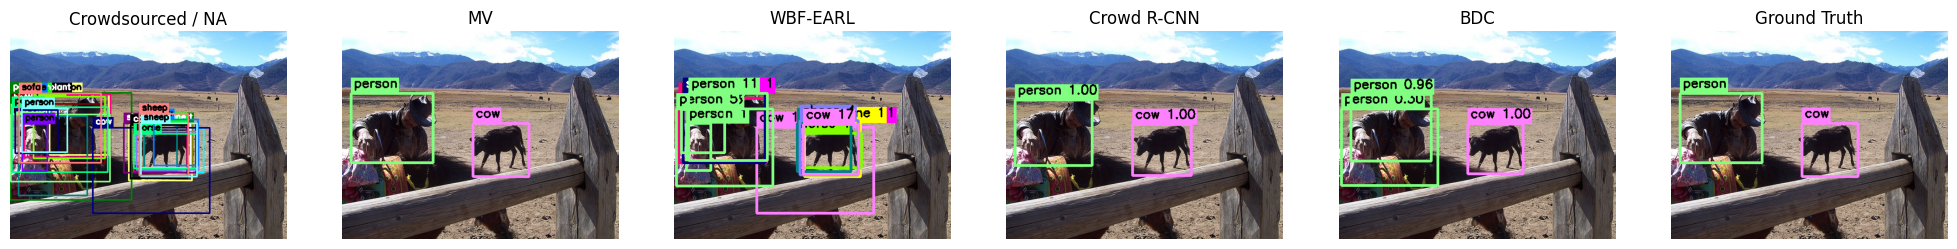

In [31]:
fig = plot_example(5, size=.75, thickness=2, save=True)

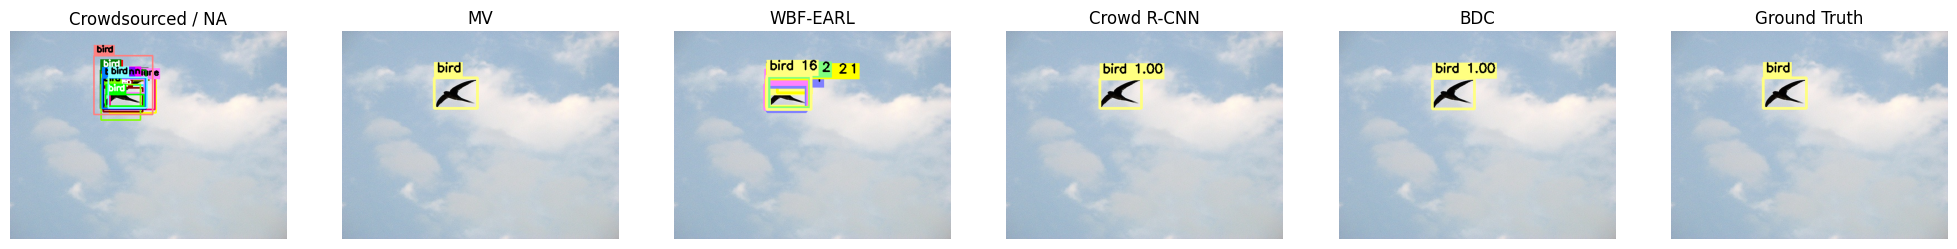

In [32]:
fig = plot_example(123, size=.75, thickness=2)

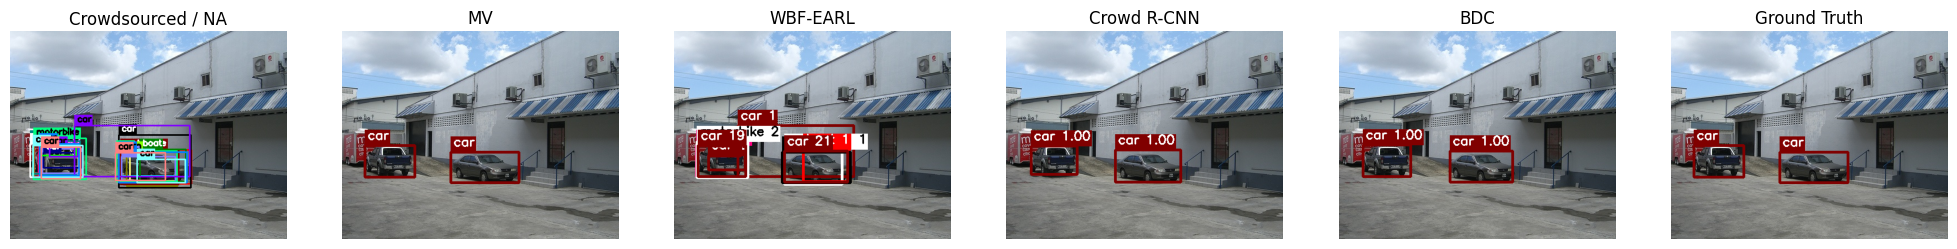

In [33]:
fig = plot_example(777, size=.75, thickness=2)

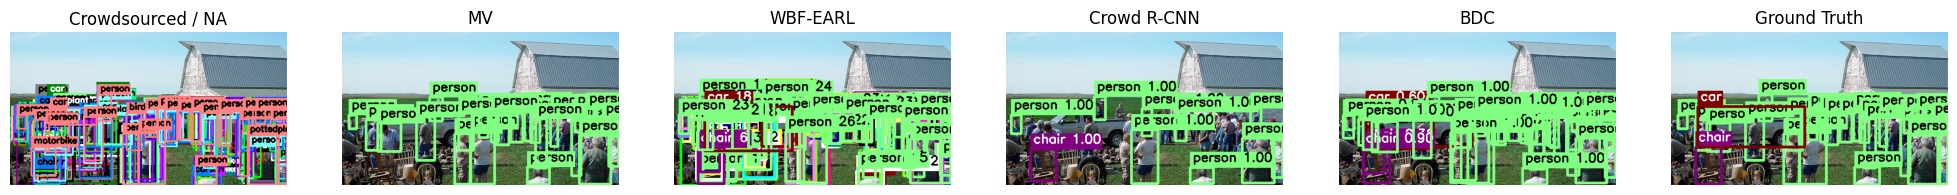

In [34]:
fig = plot_example(1111, size=.75, thickness=2, save=True)

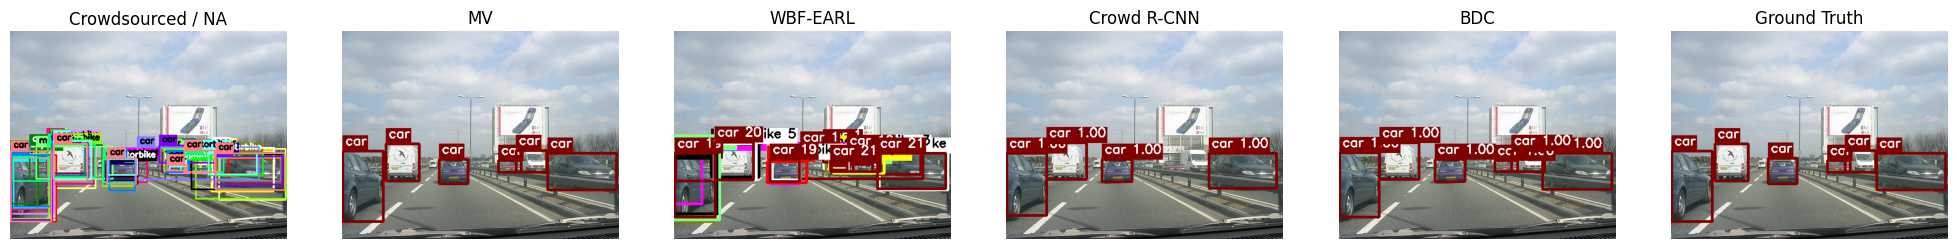

In [35]:
fig = plot_example(1234, size=.75, thickness=2, save=True)

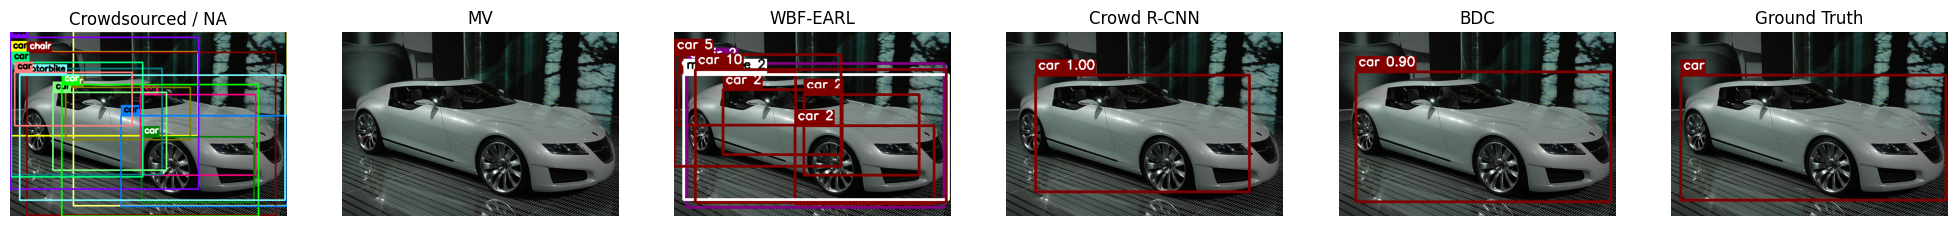

In [36]:
fig = plot_example(2109, size=.75, thickness=2, save=True)

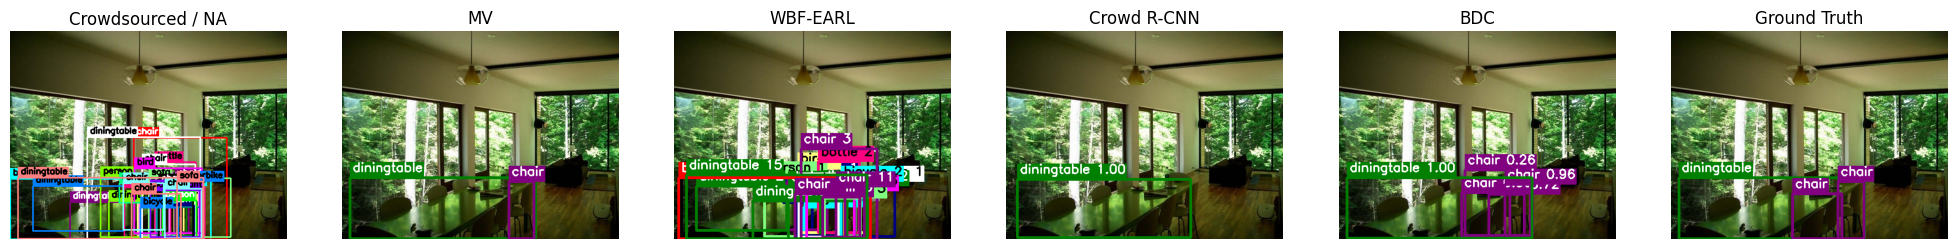

In [37]:
fig = plot_example(4612, size=.75, thickness=2, save=True)

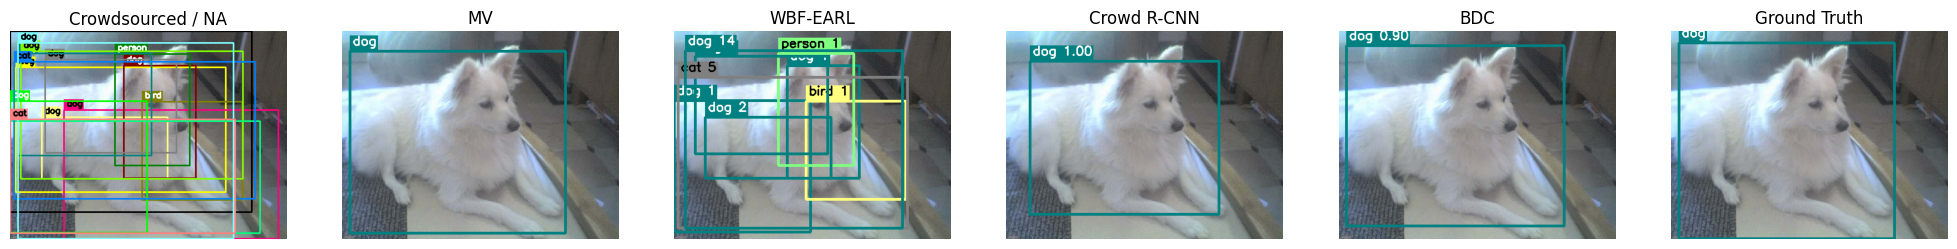

In [38]:
fig = plot_example(4904, size=.75, thickness=2, save=True)

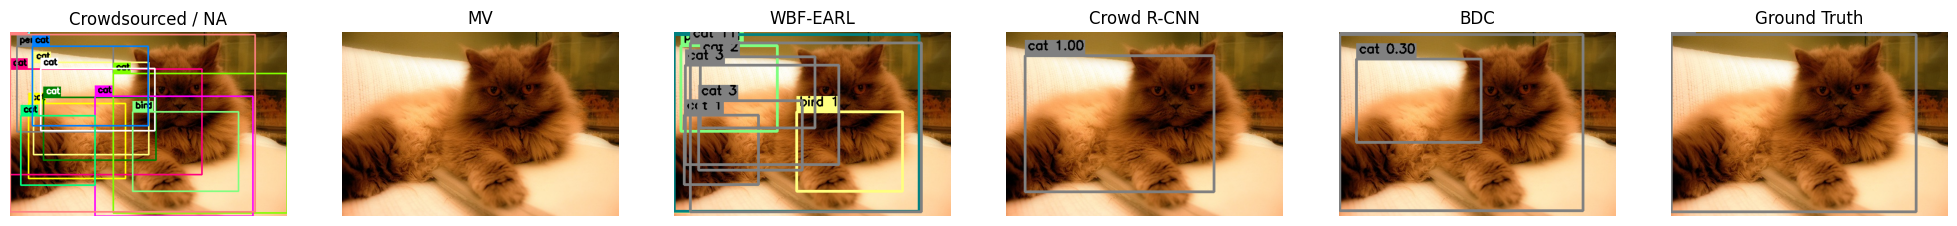

In [39]:
fig = plot_example(-888, size=.75, thickness=2)